<a href="https://dacon.io/competitions/official/136/overview/description/">대회링크</a>

# 대출 상점 총 매출 예측 경진대회

한국의 약 2,000개 상점의 신용카드 거래 내역이 제공됩니다. card_id를 기준으로 샘플링되었으며, amount의 단위는 KRW가 아닙니다. 테스트 파일에서 각 상점의 마지막 매출 발생일 다음 날부터 100일 후까지 매출의 총합을 예측해야 합니다.

 

예측한 금액만큼 100일간 대출을 진행합니다. 만약 예측한 금액보다 실제 매출이 적게 발생한다면 원금에 손실을 보게 됩니다. 실제 매출이 예측한 금액 이상으로 발생한다면, 연이율 13%의 이자가 발생합니다.



[Data]

train.csv - 카드 매출 내역, 2016-08-01부터 2018-07-31까지.


test.csv - train.csv랑 같은 형식. test.csv랑 train.csv의 store_id가 같아도 같은 상점인 것은 아님.

(월에 최소 5일 이상 데이터가 있는 상점만을 문제에 포함.)

- store_id : 각 파일에서의 상점 고유 번호 (해당기한 내 개업 혹은 폐업한 상점도 있음)

- date: 거래 일자
- time : 거래 시간
- card_id : 카드 번호의 hash 값
- amount : 매출 금액, 음수인 경우 취소 거래
- installments : 할부 개월 수. 일시불은 빈 문자열
- days_of_week : 요일, 월요일이 0, 일요일은 6
- holiday: 1이면 공휴일, 0이면 공휴일 아님


submission.csv – store_id와 total_sales 두 개의 열로 구성. store_id는 test.csv의 store_id와 대응.

# 접근방법

1. 가게마다 주 단위로 자른다
2. 주단위로 다음 주의 값을 예측한다

In [1]:
import pandas as pd
import missingno as msno
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv('C:\kaggle_data/credit/train.csv')
test = pd.read_csv('C:\kaggle_data/credit/test.csv')
ss = pd.read_csv('C:\kaggle_data/credit/submission.csv')

In [3]:
display(train.head(5))
display(test.head(5))

,store_id,date,time,card_id,amount,installments,days_of_week,holyday
0,0,2016-12-14,18:05:31,d297bba73f,5,NaN,2,0
1,0,2016-12-14,18:05:54,d297bba73f,-5,NaN,2,0
2,0,2016-12-19,12:42:31,0880849c05,144,NaN,0,0
3,0,2016-12-19,12:48:08,8b4f9e0e95,66,NaN,0,0
4,0,2016-12-19,13:31:08,7ad237eed0,24,NaN,0,0


,store_id,date,time,card_id,amount,installments,days_of_week,holyday
0,0,2016-08-01,00:28:15,bf33518373,125,NaN,0,0
1,0,2016-08-01,01:09:58,7a19a3a92f,90,NaN,0,0
2,0,2016-08-01,01:47:24,6f9fd7e241,150,NaN,0,0
3,0,2016-08-01,17:54:43,8bcf1d61b2,362,NaN,0,0
4,0,2016-08-01,18:48:53,6a722ce674,125,NaN,0,0


In [4]:
train.info(verbose=True, null_counts=True) # non-nullcounts가 안 나오는 경우

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3362796 entries, 0 to 3362795
Data columns (total 8 columns):
 #   Column        Non-Null Count    Dtype  
---  ------        --------------    -----  
 0   store_id      3362796 non-null  int64  
 1   date          3362796 non-null  object 
 2   time          3362796 non-null  object 
 3   card_id       3362796 non-null  object 
 4   amount        3362796 non-null  int64  
 5   installments  16860 non-null    float64
 6   days_of_week  3362796 non-null  int64  
 7   holyday       3362796 non-null  int64  
dtypes: float64(1), int64(4), object(3)
memory usage: 205.2+ MB


In [5]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 473392 entries, 0 to 473391
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   store_id      473392 non-null  int64  
 1   date          473392 non-null  object 
 2   time          473392 non-null  object 
 3   card_id       473392 non-null  object 
 4   amount        473392 non-null  int64  
 5   installments  1779 non-null    float64
 6   days_of_week  473392 non-null  int64  
 7   holyday       473392 non-null  int64  
dtypes: float64(1), int64(4), object(3)
memory usage: 28.9+ MB


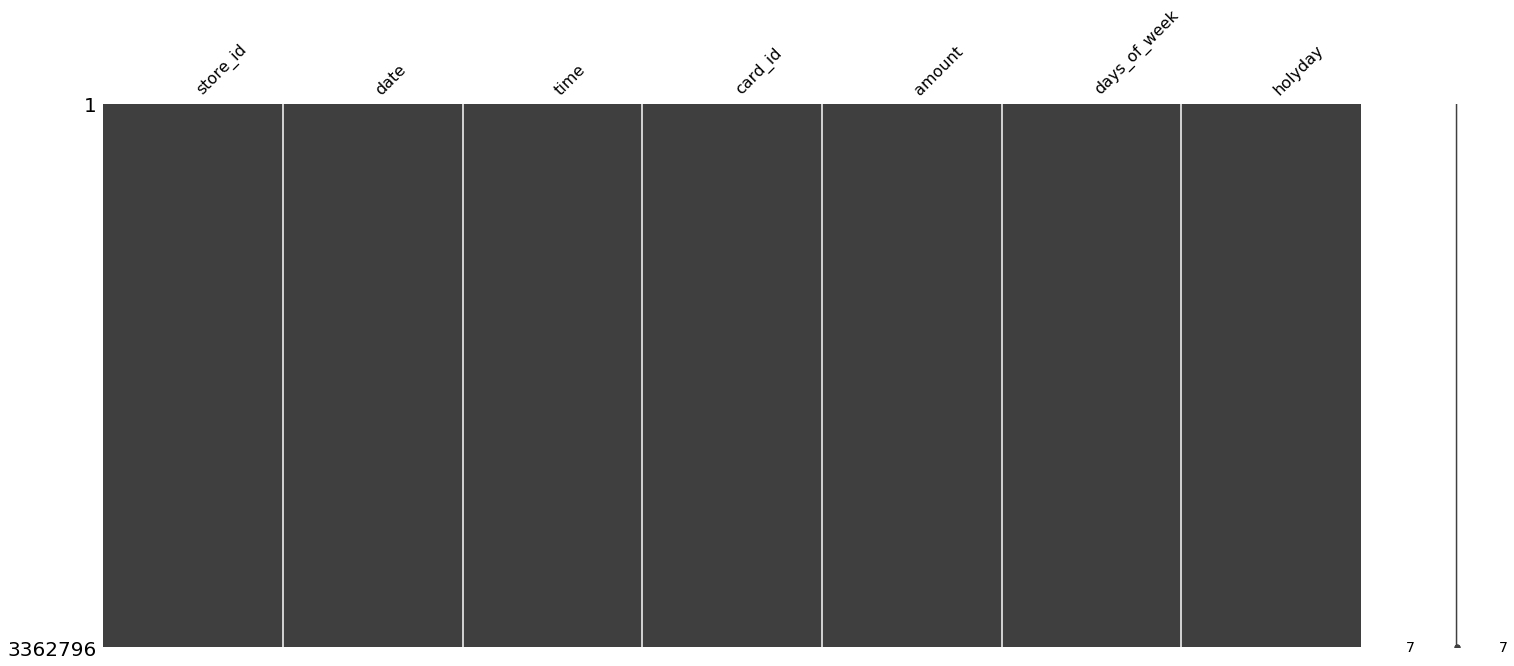

In [6]:
msno.matrix(train[['store_id', 'date', 'time', 'card_id', 'amount', 'days_of_week', 'holyday']])

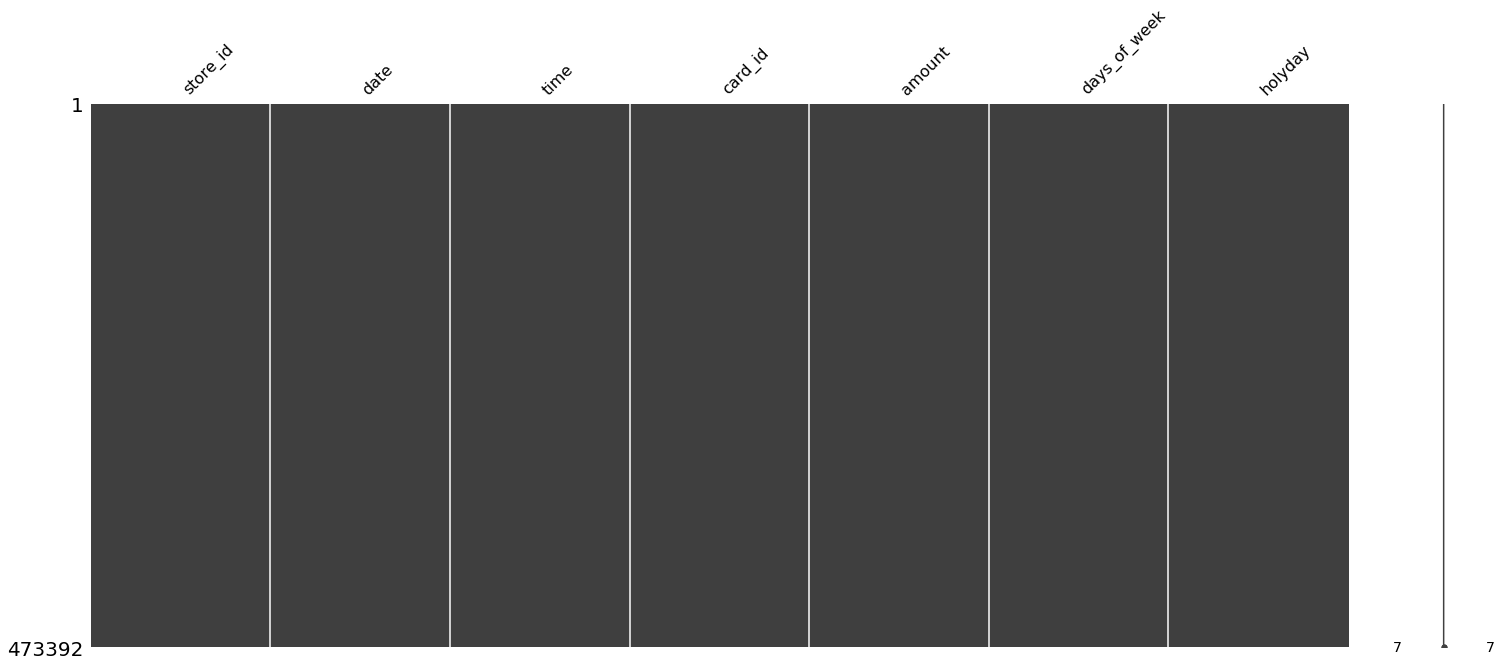

In [7]:
msno.matrix(test[['store_id', 'date', 'time', 'card_id', 'amount', 'days_of_week', 'holyday']])

# date는 datetime객체로 바꿔주자


In [128]:
def date_idx(df):
    df['date_idx'] = pd.DatetimeIndex(df['date'])
    df = df.set_index('date_idx')
    return df

In [130]:
train = date_idx(train)
test = date_idx(test)

In [131]:
train

,store_id,date,time,card_id,amount,installments,days_of_week,holyday
date_idx,,,,,,,,
2016-12-14,0,2016-12-14,18:05:31,d297bba73f,5,NaN,2,0
2016-12-14,0,2016-12-14,18:05:54,d297bba73f,-5,NaN,2,0
2016-12-19,0,2016-12-19,12:42:31,0880849c05,144,NaN,0,0
2016-12-19,0,2016-12-19,12:48:08,8b4f9e0e95,66,NaN,0,0
2016-12-19,0,2016-12-19,13:31:08,7ad237eed0,24,NaN,0,0
...,...,...,...,...,...,...,...,...
2018-07-19,1799,2018-07-19,17:58:31,e254bf70d9,600,NaN,3,0
2018-07-19,1799,2018-07-19,18:54:34,8f41c89891,275,NaN,3,0
2018-07-22,1799,2018-07-22,14:46:57,aeb64fe1fb,350,NaN,6,0


# 7일 단위로 resampling
- 2016년 8월 1일은 월요일
- resample 후 나오는 값의 의미는 index까지의 집계

In [114]:
temp = train[train['store_id']==1]

In [209]:
temp = train.drop(['card_id','time','days_of_week','holyday','installments'],1)
temp

,store_id,date,amount
date_idx,,,
2016-12-14,0,2016-12-14,5
2016-12-14,0,2016-12-14,-5
2016-12-19,0,2016-12-19,144
2016-12-19,0,2016-12-19,66
2016-12-19,0,2016-12-19,24
...,...,...,...
2018-07-19,1799,2018-07-19,600
2018-07-19,1799,2018-07-19,275
2018-07-22,1799,2018-07-22,350


In [200]:
temp_0 = temp['amount'].resample('1W').sum()
temp_0 = pd.DataFrame(temp_0)
temp_0['target'] = temp_0['amount'].shift(-1).fillna(0).astype('int')
temp_0 = temp_0.reset_index()
temp_0['year'], temp_0['month'], temp_0['day'] = 0,0,0
for i in range(len(temp_0)):
    temp_0.loc[i,'year'] = temp_0['date'][i].year
    temp_0.loc[i,'month'] = temp_0['date'][i].month
    temp_0.loc[i, 'day'] = temp_0['date'][i].day

# 함수화
- df를 넣어준다
- 필요없는 칼럼 드랍
- date로 인덱싱
- store_id별로 for문을 돌린다
    - 주단위 집계한다
    - year, month, day로 columns을 나눠서 리턴
- lst에 append해둔다
- concat하여 반환한다

In [212]:
for i in train['store_id'].unique():
    print(i)

0
1
2
3
4
5
6
7
8
9
10
12
13
14
15
16
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280

In [17]:
def resam_1w(df):
    df = df.drop(['card_id','time','days_of_week','holyday','installments'],1)
    df['date_idx'] = pd.DatetimeIndex(df['date'])
    df = df.set_index('date_idx')
    store_lst = []
    for store_id in df['store_id'].unique():
    
        temp = df[df['store_id']==store_id]
        temp_0 = temp['amount'].resample('1W').sum()
        temp_0 = pd.DataFrame(temp_0)
        temp_0['target'] = temp_0['amount'].shift(-1).fillna(0).astype('int')
        temp_0 = temp_0.reset_index()
        
        
        temp_0['year'], temp_0['month'], temp_0['day'] = 0,0,0
        for i in range(len(temp_0)):
            temp_0.loc[i,'year'] = temp_0['date_idx'][i].year
            temp_0.loc[i,'month'] = temp_0['date_idx'][i].month
            temp_0.loc[i, 'day'] = temp_0['date_idx'][i].day
        temp_0['store_id'] = store_id
        store_lst.append(temp_0)
        
    return pd.concat(store_lst)

In [19]:
%%time
train = resam_1w(train)
test = resam_1w(test)

Wall time: 1min 36s


In [23]:
train = train.drop('date_idx',1)
test = test.drop('date_idx',1)

In [26]:
train['year'] = train['year'] - 2016
test['year'] = test['year'] - 2016

In [33]:
train['day'] = train['day']/31
test['day'] = test['day']/31

In [35]:
y = train.pop('target')

In [36]:
train

,amount,year,month,day,store_id
0,0,0,12,0.580645,0
1,83568,0,12,0.806452,0
2,65464,1,1,0.032258,0
3,63019,1,1,0.258065,0
4,72032,1,1,0.483871,0
...,...,...,...,...,...
69,0,2,7,0.258065,1799
70,1225,2,7,0.483871,1799
71,1925,2,7,0.709677,1799
72,300,2,7,0.935484,1799


# 할 일
- 스토어 아이디별로 

In [40]:
for i in train['store_id'].unique():
    temp = train[train['store_id']==i]
    print(len(temp))

86
81
105
105
60
103
105
104
105
37
45
105
105
105
103
70
105
42
41
17
105
105
95
22
105
104
105
23
88
5
104
101
63
48
105
101
48
102
49
104
7
34
98
89
54
102
72
105
105
105
9
80
59
89
77
40
105
105
4
35
38
105
105
27
59
105
105
38
105
54
105
94
8
93
41
41
26
60
38
97
18
30
54
62
59
36
101
67
22
16
12
18
19
36
104
104
42
105
9
10
56
105
96
104
74
23
105
105
96
29
101
26
39
29
104
105
87
26
105
100
104
103
99
105
30
87
32
56
53
22
50
46
51
37
72
105
79
105
66
105
55
105
53
31
19
50
87
21
100
27
68
97
105
37
87
104
33
103
31
48
39
6
71
105
46
18
52
94
102
34
95
105
105
47
44
17
58
71
58
101
14
52
105
50
60
105
49
68
48
34
48
62
105
105
41
30
100
53
1
27
12
70
96
24
105
7
104
104
38
81
21
57
105
104
100
34
75
71
105
105
105
85
96
84
69
56
6
102
97
86
102
105
104
105
37
34
105
105
37
26
27
63
105
70
105
13
105
104
103
47
102
13
24
105
105
23
20
105
104
77
63
26
67
67
105
105
31
24
6
57
92
65
105
63
99
98
97
101
56
25
105
72
52
104
30
105
97
103
105
105
34
14
105
39
49
105
32
104
72
15
42
1